In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from datafold.appfold import EDMDControl
from datafold.dynfold.dmd import ControlledAffineDynamicalSystem, gDMDAffine
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis
from datafold.pcfold import InitialCondition, InverseQuadraticKernel, TSCDataFrame
from datafold.utils.general import if1dim_colvec, if1dim_rowvec
from datafold.utils._systems import InvertedPendulum

## Predictor

### Random system of the form `xdot = A @ x + B @ u @ x`

<AxesSubplot:xlabel='time'>

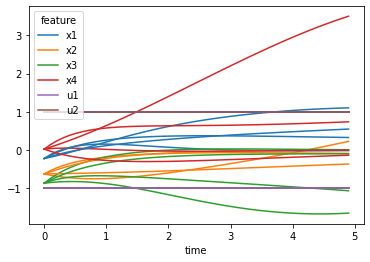

In [3]:
state_size = 4
input_size = 2
n_timesteps = 50
n_ic = 1

gen = np.random.default_rng(22)

A = gen.uniform(-0.5, 0.5, size=(state_size, state_size))
np.fill_diagonal(A, gen.uniform(-1.0, -0.5, size=state_size))
x0 = gen.uniform(-1.0, 1.0, size=(state_size, n_ic))
x0 = np.hstack([x0, x0, x0, x0])
Bi = np.stack(
    [gen.uniform(-0.5, 0.5, size=(state_size, state_size)) for i in range(input_size)],
    2,
)
u = np.concatenate(
    [
        np.ones((n_ic, n_timesteps, input_size)),
        -np.ones((n_ic, n_timesteps, input_size)),
        np.stack([np.ones((n_ic, n_timesteps)), -np.ones((n_ic, n_timesteps))], 2),
        np.stack([-np.ones((n_ic, n_timesteps)), np.ones((n_ic, n_timesteps))], 2),
    ],
    0,
)
t = np.linspace(0, n_timesteps - 1, n_timesteps) * 0.1
names = ["x" + str(i + 1) for i in range(state_size)]

tsc_df = (
    ControlledAffineDynamicalSystem()
    .setup_matrix_system(A, Bi)
    .evolve_system(x0, u, time_values=t, time_delta=0.1, feature_names_out=names)
)
# print(tsc_df)
# print(A)
# print(Bi)
ureshaped = u.reshape((-1, input_size))
for i in range(input_size):
    tsc_df["u" + str(i + 1)] = ureshaped[:, i]
tsc_df.plot()

In [4]:
dmd = gDMDAffine().fit(tsc_df, split_by="name", control=["u1", "u2"])

<AxesSubplot:xlabel='time'>

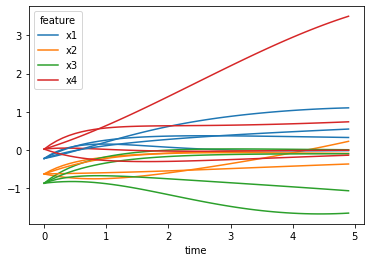

In [5]:
tsc_pred = dmd.fit_predict(tsc_df)
tsc_pred.plot()

<AxesSubplot:xlabel='time'>

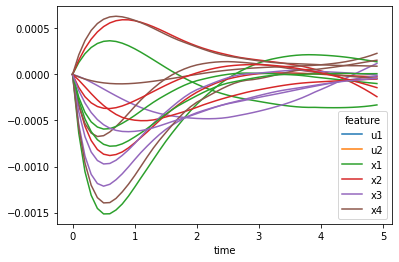

In [6]:
(tsc_df - tsc_pred).plot()

### Duffing

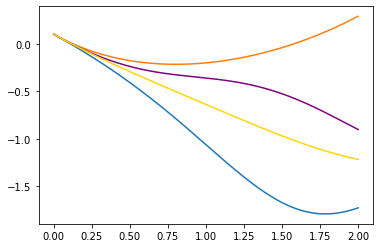

In [290]:
def duffing(t, x, alpha=-1, beta=1, delta=0.6, u=lambda t: 1):
    xdot = np.array([x[1], 0])
    xdot[1] = -delta * x[1] - alpha * x[0] - beta * x[0] ** 3 + u(t)
    return xdot


def simulate(x0, u=lambda t: 1, N=201, t0=0, tf=2):
    sol = solve_ivp(
        lambda t, x: duffing(t, x, u=u), (t0, tf), x0, t_eval=np.linspace(t0, tf, N)
    )
    if not sol.success:
        raise RuntimeError("Couldn't not evolve the system.")
    df = pd.DataFrame(data=sol.y.T, index=sol.t, columns=["x", "xdot"])
    df["u"] = u(sol.t)
    return df


x0 = np.array([0.1, -0.9])
x = simulate(x0, lambda t: -1)
plt.plot(x["x"])
x = simulate(x0)
plt.plot(x["x"])
x = simulate(x0, lambda t: np.sin(np.pi * t))
plt.plot(x["x"], "purple")
x = simulate(x0, lambda t: 0)
plt.plot(x["x"], "gold")

<AxesSubplot:xlabel='time'>

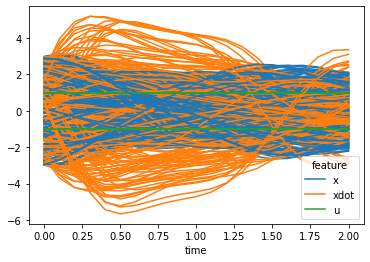

In [8]:
n_repeats = 100
rng = np.random.default_rng(0)
dflist = []
for i in range(n_repeats):
    random_x0 = rng.uniform(-3, 3, 2)
    dflist.append(simulate(random_x0, N=21))
    dflist.append(simulate(random_x0, lambda t: -1, N=21))
duffing_tsc = TSCDataFrame.from_frame_list(dflist)
duffing_tsc.plot()

In [164]:
edmd_duffing = EDMDControl(
    dict_steps=[
        ("poly", TSCPolynomialFeatures(5, include_bias=True)),
    ],
    dmd_model=gDMDAffine(rcond=1e-6),
)
edmd_duffing.fit(duffing_tsc, split_by="name", control=["u"]);

Sys eigenvalues:  [-0.42300014+9.07708779j -0.42300014-9.07708779j -0.84047692+7.74788093j
 -0.84047692-7.74788093j -1.17740166+6.50221497j -1.17740166-6.50221497j
 -0.3996999 +4.259072j   -0.3996999 -4.259072j   -1.37923337+4.23971052j
 -1.37923337-4.23971052j -1.43505214+2.68108083j -1.43505214-2.68108083j
 -0.26159987+2.39787721j -0.26159987-2.39787721j -0.76134794+1.51027637j
 -0.76134794-1.51027637j -0.09311429+0.62604222j -0.09311429-0.62604222j
 -0.76447609+0.16956686j -0.76447609-0.16956686j  0.        +0.j        ]
Control eigenvalues:  [ 7.72184009e-01+0.34537432j  7.72184009e-01-0.34537432j
 -6.80134277e-01+0.31312677j -6.80134277e-01-0.31312677j
  2.15720685e-01+0.3658548j   2.15720685e-01-0.3658548j
 -1.81910672e-01+0.39014529j -1.81910672e-01-0.39014529j
 -1.60686171e-01+0.j         -2.34620679e-02+0.11808446j
 -2.34620679e-02-0.11808446j -3.74616316e-02+0.j
 -7.05140924e-03+0.0293165j  -7.05140924e-03-0.0293165j
  3.75727507e-02+0.j          3.33612254e-02+0.j
  1.814501

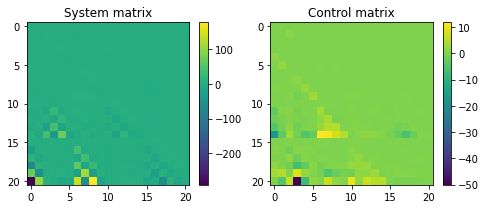

In [10]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(edmd_duffing.sys_matrix)
plt.colorbar()
plt.title("System matrix")
print("Sys eigenvalues: ", np.linalg.eigvals(edmd_duffing.sys_matrix))
plt.subplot(122)
plt.imshow(edmd_duffing.control_matrix[:, :, 0])
plt.colorbar()
plt.title("Control matrix")
print("Control eigenvalues: ", np.linalg.eigvals(edmd_duffing.control_matrix[:, :, 0]))

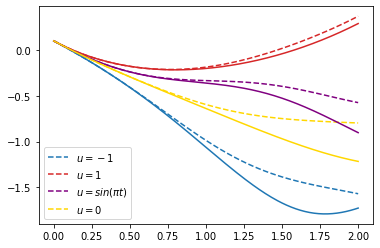

In [11]:
n_samples = 50
t = np.linspace(0, 2, n_samples)
pred0 = edmd_duffing.predict(
    InitialCondition.from_array(x0, columns=["x", "xdot"]),
    time_values=t,
    control_input=-np.ones(n_samples),
)
plt.plot(t, pred0["x"].values, "tab:blue", label=r"$u=-1$", linestyle="--")
pred0 = edmd_duffing.predict(
    InitialCondition.from_array(x0, columns=["x", "xdot"]),
    time_values=t,
    control_input=np.ones(n_samples),
)
plt.plot(t, pred0["x"].values, "tab:red", label=r"$u=1$", linestyle="--")
pred0 = edmd_duffing.predict(
    InitialCondition.from_array(x0, columns=["x", "xdot"]),
    time_values=t,
    control_input=np.sin(np.pi * t),
)
plt.plot(t, pred0["x"].values, "purple", label=r"$u=sin(\pi t)$", linestyle="--")
pred0 = edmd_duffing.predict(
    InitialCondition.from_array(x0, columns=["x", "xdot"]),
    time_values=t,
    control_input=0 * np.ones(n_samples),
)
plt.plot(t, pred0["x"].values, "gold", label=r"$u=0$", linestyle="--")
x = simulate(x0, lambda t: -1)
plt.plot(x["x"], "tab:blue")
x = simulate(x0)
plt.plot(x["x"], "tab:red")
x = simulate(x0, lambda t: np.sin(np.pi * t))
plt.plot(x["x"], "purple")
x = simulate(x0, lambda t: 0)
plt.plot(x["x"], "gold")
plt.legend();

### Inverted Pendulum

In [12]:
state_cols = ["x", "xdot", "theta", "thetadot"]
control_cols = ["u"]

# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20  # -
ic = InitialCondition.from_array(np.array([0, 0, np.pi, 0]), columns=state_cols)

invertedPendulum = InvertedPendulum(initial_condition=ic.values)

Xlist, Ulist = [], []
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9 * np.random.random()
    control_frequency = np.pi + 2 * np.pi * np.random.random()
    control_phase = 2 * np.pi * np.random.random()
    control_func = lambda t, y: control_amplitude * np.sin(
        control_frequency * t + control_phase
    )
    invertedPendulum.reset()
    traj = invertedPendulum.predict(
        time_step=sim_time_step,
        num_steps=sim_num_steps,
        control_func=control_func,
    )
    assert (
        invertedPendulum.sol.success
    ), f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=state_cols)
    dfx[control_cols] = 0.0
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=control_cols)
    for col in state_cols:
        dfu[col] = 0.0
    dfu = dfu[state_cols + control_cols]
    Ulist.append(dfu)

X_tsc = TSCDataFrame.from_frame_list(Xlist)[state_cols]
X_tsc[control_cols] = TSCDataFrame.from_frame_list(Ulist)[control_cols]

In [13]:
num_rbfs = 20
eps = 1

rbf = TSCRadialBasis(
    kernel=InverseQuadraticKernel(epsilon=eps), center_type="fit_params"
)
center_ids = sorted(
    np.random.choice(
        range(0, sim_num_steps * training_size), size=num_rbfs, replace=False
    )
)
centers = X_tsc.iloc[center_ids].values

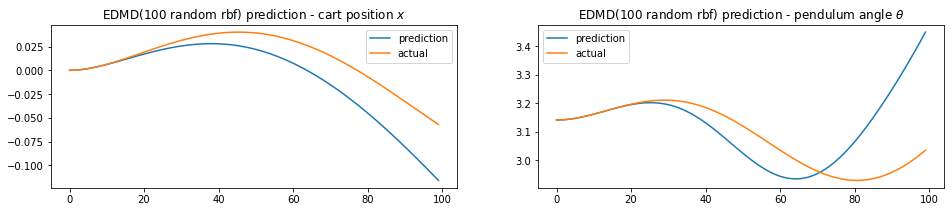

In [14]:
edmdrbf = EDMDControl(
    dict_steps=[
        ("rbf", rbf),
    ],
    include_id_state=True,
    dmd_model=gDMDAffine(rcond=1e-6),
)

edmdrbf.fit(
    X_tsc,
    split_by="name",
    state=state_cols,
    control=control_cols,
    rbf__centers=centers[:, :-1],
)
rbfprediction = edmdrbf.predict(
    ic, control_input=np.atleast_2d(control_input).T, time_values=t
)
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(rbfprediction["x"].values[:100], label="prediction")
plt.plot(dfx["x"].values[:100], label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - cart position $x$")
plt.subplot(122)
plt.plot(rbfprediction["theta"].values[:100], label="prediction")
plt.plot(dfx["theta"].values[:100], label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - pendulum angle $\theta$");

In [15]:
edmdrbf.predict(
    ic, control_input=np.atleast_2d(control_input[:10]).T, time_values=t[:10]
)

feature         x      xdot     theta  thetadot
ID time                                        
0  0.00  0.000000  0.000000  3.141593  0.000000
   0.01  0.000082  0.016407  3.141848  0.050483
   0.02  0.000321  0.031281  3.142591  0.097946
   0.03  0.000702  0.044676  3.143793  0.142194
   0.04  0.001209  0.056651  3.145419  0.183033
   0.05  0.001828  0.067264  3.147436  0.220272
   0.06  0.002548  0.076579  3.149808  0.253726
   0.07  0.003354  0.084659  3.152494  0.283215
   0.08  0.004235  0.091570  3.155455  0.308560
   0.09  0.005179  0.097382  3.158646  0.329592

## KMPC

### Implementation

In [380]:
class KMPC_Peitz(object):
    def __init__(
            self,
            predictor: EDMDControl,
            horizon: int,
            input_bounds: np.array,
            cost_state: np.array,
            cost_input: np.array,
        ):
        self.predictor = predictor

        self.horizon = horizon

        self.L = predictor.sys_matrix
        self.B = predictor.control_matrix
        self.lifted_state_size, _, self.input_size = self.B.shape
        self.state_size = len(predictor.state_columns)

        self.input_bounds = np.repeat(input_bounds.T,self.horizon+1,axis=1).T
        self.cost_state = cost_state
        self.cost_input = cost_input
        self._cached_input = None
        self._cached_state = None
        self._cached_prediction = None
    
    def _predict(self, x0, u, t):
        # -> shape (self.lifted_state_size, self.horizon+1)
        if (self._cached_input != u).any() or (self._cached_state != x0).any:
            tsc = self.predictor.predict(
                InitialCondition.from_array(x0.T,self.predictor.state_columns),
                control_input=u.T[np.newaxis],
                time_values=t,
                lifted_state=True,
                check_inputs=False)
            self._cached_prediction = tsc.values.T
            self._cached_input = u
            self._cached_state = x0
        return self._cached_prediction

    def cost(self, u, x0, xref, t):
        """_summary_

        Parameters
        ----------
        u : np.array
            shape = (n*m,)
            [u1(t0) u1(t1) ... u1(tn) u2(t1) ... um(tn)]
            with `n = self.horizon+1`; `m = self.input_size`
        x0 : np.array
            shape = `(self.state_size, 1)`
        xref : np.array
            shape = `(self.state_size, 1)`

        Returns
        ---------
        float
        """
        u = u.reshape(self.input_size, self.horizon+1)
        x= self._predict(x0, u, t)[:self.state_size,:]
        Lhat = self.cost_state*np.linalg.norm(x-xref,axis=0)+self.cost_input*np.linalg.norm(u,axis=0)
        J = np.sum(Lhat)
        #print('J', J)
        #print('u', u)
        #print('x', x)
        return J
    
    def jacobian(self, u, x0, xref, t):
        """_summary_

        Parameters
        ----------
        u : np.array
            shape = (n*m,)
            [u1(t0) u1(t1) ... u1(tn) u2(t1) ... um(tn)]
            with `n = self.horizon+1`; `m = self.input_size`
        x0 : np.array
            shape = `(self.state_size, 1)`
        xref : np.array
            shape = `(self.state_size, 1)`

        Returns
        ---------
        array_like, shape (n*m,)
        [dJ/du1(t0) dJ/du1(t1) ... dJ/du1(tn) dJ/du2(t1) ... dJ/dum(tn)]
        """
        u = u.reshape(self.input_size, self.horizon+1)
        x= self._predict(x0, u, t) # shape = (lifted_state_size, horizon+1)
        interp_gamma = interp1d(t,self._dcost_dx(x, xref),axis=1)
        interp_u = interp1d(t,u,axis=1)
        
        lambda_adjoint = self._compute_lambda_adjoint(interp_u, interp_gamma, t) # shape = (lifted_state_size,horizon+1)
        rho = self._dcost_du(u) # shape = (input_size, horizon+1)

        # self.B.shape = (lifted_state_size, lifted_state_size, input_size)
        # (x.T @ self.B.T).shape = (input_size, horizon+1, lifted_state_size)
        # einsum(...).shape = rho.shape = (input_size, horizon+1)
        jac = np.einsum('ijk,kj->ij',x.T @ self.B.T, lambda_adjoint) + rho
        #print('jac', jac)
        #print(lambda_adjoint)
        return jac.ravel()
        
    def _lambda_ajoint_ODE(self, t, y, interp_u, interp_gamma):
        return -interp_gamma(t) - self.L.T @ y - np.einsum("ijk,i->jk",self.B.T, interp_u(t)) @ y

    def _compute_lambda_adjoint(self, interp_u, interp_gamma, t):
        sol = solve_ivp(
                self._lambda_ajoint_ODE,
                y0=np.zeros(self.lifted_state_size),
                t_span=[t[-1],t[0]],
                t_eval=t[::-1],
                args=(interp_u, interp_gamma)
            )
        if not sol.success:
            raise RuntimeError("Could not integrate the adjoint dynamics. Solver says '{sol.message}'")
        return np.fliplr(sol.y)

    def _dcost_dx(self, x, xref):
        #gamma(t0:te)
        gamma = np.zeros((self.lifted_state_size, self.horizon+1))
        gamma[:self.state_size, :] = self.cost_state*2*(x[:self.state_size,:]-xref)
        return gamma
    
    def _dcost_du(self, u):
        #rho(t0:te)
        return self.cost_input*2*(u)

    def  generate_control_signal(self, x0, xref, t,**minimization_kwargs):
        # x0.shape = (nc,1)
        # xref.shape = (nc,n)
        # t.shape = (n,)
        if t.shape != (self.horizon+1,):
            raise ValueError(f't is of shape {t.shape}, should be ({self.horizon+1},)')
        u_init = np.zeros((self.input_size,self.horizon+1)).ravel() #[u1(t1) u1(t2) ... u1(tn) u2(t1) ... um(tn)]
        res = minimize(
            fun=self.cost,
            x0=u_init,
            args=(if1dim_colvec(x0),if1dim_colvec(xref),t),
            method='L-BFGS-B',
            jac=self.jacobian,
            bounds=self.input_bounds,
            **minimization_kwargs,
        )
        
        if not res.success:
            raise RuntimeError(f"Could not find a minimum solution. Solver says '{res.message}'")

        return res.x.reshape(self.input_size, self.horizon+1)

### Duffing

In [383]:
horizon_size = 5
horizon_time = 1
kmpc_duffing = KMPC_Peitz(edmd_duffing, horizon=horizon_size, input_bounds=np.array([[-1,1]]), cost_state=1, cost_input=0)
x0 = np.array([0.15, -0.9])
t = np.linspace(0,horizon_time,horizon_size+1)
xref = np.zeros((2,horizon_size+1))
#xref[0,100:200] = 1.0
#xref[0,200:300] = -1.0
%prun -s "cumulative" u = kmpc_duffing.generate_control_signal(x0,xref,t,tol=1e-3)

         1200082 function calls (1190480 primitive calls) in 12.639 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.639   12.639 {built-in method builtins.exec}
        1    0.000    0.000   12.638   12.638 <string>:1(<module>)
        1    0.000    0.000   12.638   12.638 1604406645.py:127(generate_control_signal)
        1    0.000    0.000   12.638   12.638 _minimize.py:45(minimize)
        1    0.001    0.001   12.638   12.638 lbfgsb.py:210(_minimize_lbfgsb)
       12    0.001    0.000   11.946    0.995 1604406645.py:26(_predict)
        6    0.003    0.001    9.626    1.604 _differentiable_functions.py:264(fun_and_grad)
       12    0.038    0.003    7.954    0.663 edmd.py:2160(predict)
      432    0.314    0.001    7.721    0.018 collection.py:788(_validate_index)
      144    0.012    0.000    7.475    0.052 collection.py:904(_validate)
        7    0.000    0.000    6.547    0.935

#### Long horizon

In [348]:
horizon_size = 20
horizon_time = 5
kmpc_duffing = KMPC_Peitz(edmd_duffing, horizon=horizon_size, input_bounds=np.array([[-1,1]]), cost_state=1, cost_input=0)
x0 = np.array([0.15, -0.9])
t = np.linspace(0,horizon_time,horizon_size+1)
xref = np.zeros((2,horizon_size+1))
#xref[0,100:200] = 1.0
#xref[0,200:300] = -1.0
u = kmpc_duffing.generate_control_signal(x0,xref,t,tol=1e-3)

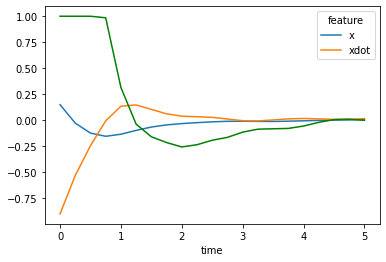

In [349]:
edmd_duffing.predict(x0, time_values=t, control_input=u.T).plot()
plt.plot(t,u.T,color='g')

<AxesSubplot:>

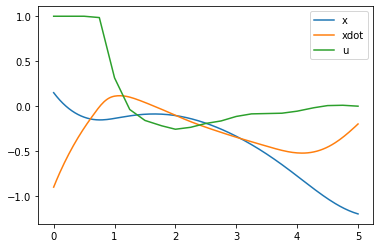

In [350]:
u_interp = interp1d(t, u)
x = simulate(x0, lambda t: u_interp(t).T, tf=5)
x.plot()


#### Sliding window

In [390]:
horizon_size = 5
dt = 0.4
horizon_time = horizon_size*dt
total_time = 20
timesteps = int(total_time/dt)
t = np.arange(timesteps+1)*dt
ulist = []
xlist = []
xref = np.zeros((2,timesteps+1))
xref[0,25:50] = 1.0
#xref[0,200:300] = -1.0
x0 = np.array([0.1, -0.9])
kmpc_duffing = KMPC_Peitz(edmd_duffing, horizon=horizon_size, input_bounds=1.1*np.array([[-1,1]]), cost_state=1, cost_input=0)
xx0 = x0
for i in range(int(total_time/horizon_time)):
    xxref = xref[:,i*horizon_size:(i+1)*horizon_size+1]
    tt = t[i*horizon_size:(i+1)*horizon_size+1]
    u = kmpc_duffing.generate_control_signal(xx0,xxref,tt,tol=1e-3,options={'ftol':1e-3})
    u_interp = interp1d(tt, u)
    xx = simulate(xx0, lambda t: u_interp(t).T, N=horizon_size+1, t0=tt[0], tf=tt[-1])
    xx0 = xx[['x','xdot']].values[-1]
    print(f"{i}/{int(total_time/horizon_time)}")
    xlist.append(xx.iloc[:-1])


0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


<AxesSubplot:xlabel='time'>

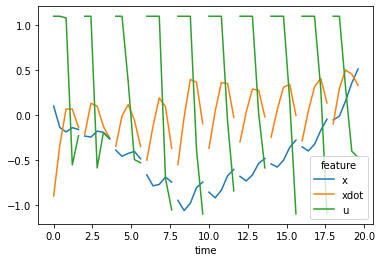

In [391]:
TSCDataFrame.from_frame_list(xlist).plot()


## Appendix 
### Einsum test

In [16]:
np.einsum(
    "ij,ik->ijk",
    np.array([[1, -1], [2, -2], [3, -3]]),
    np.array([[0.1, 0.2, 0.3, 0.4], [1.1, 1.2, 1.3, 1.4], [10.1, 12.1, 13.1, 14.1]]),
).reshape(3, 2 * 4)

array([[  0.1,   0.2,   0.3,   0.4,  -0.1,  -0.2,  -0.3,  -0.4],
       [  2.2,   2.4,   2.6,   2.8,  -2.2,  -2.4,  -2.6,  -2.8],
       [ 30.3,  36.3,  39.3,  42.3, -30.3, -36.3, -39.3, -42.3]])

In [17]:
np.einsum(
    "ij,ik->ijk",
    np.array([[0.1, 0.2, 0.3, 0.4], [1.1, 1.2, 1.3, 1.4], [10.1, 12.1, 13.1, 14.1]]),
    np.array([[1, -1], [2, -2], [3, -3]]),
).reshape(3, 2 * 4)

array([[  0.1,  -0.1,   0.2,  -0.2,   0.3,  -0.3,   0.4,  -0.4],
       [  2.2,  -2.2,   2.4,  -2.4,   2.6,  -2.6,   2.8,  -2.8],
       [ 30.3, -30.3,  36.3, -36.3,  39.3, -39.3,  42.3, -42.3]])

### IVP backwards test

array([[ 0.95890863,  1.06091234,  1.16200138,  1.2609758 ,  1.35671663,
         1.44818588,  1.53442656,  1.61456261,  1.68779902,  1.7534217 ,
         1.81079757,  1.85937454,  1.89868147,  1.92832823,  1.94800565,
         1.95748555,  1.95662074,  1.945345  ,  1.92367126,  1.89160116,
         1.84957145,  1.79824184,  1.73830209,  1.67047203,  1.59550153,
         1.51417052,  1.42728898,  1.33569695,  1.24026454,  1.14189188,
         1.04150919,  0.94007673,  0.83858481,  0.7380538 ,  0.63953414,
         0.5441063 ,  0.45288083,  0.36699832,  0.28762941,  0.21560764,
         0.15131847,  0.09544138,  0.04855961,  0.01115529, -0.01639052,
        -0.03379792, -0.04088806, -0.03758324, -0.02390693,  0.        ]])

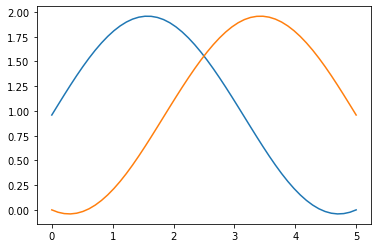

In [333]:
sol = solve_ivp(lambda t,y: np.cos(t),y0=np.array([0]),t_span=[5,0.],t_eval=np.linspace(5,0.))
plt.plot(sol.t,sol.y.T)
plt.plot(np.linspace(0,5),sol.y.T)
np.fliplr(sol.y)

### Einsum test 2

In [70]:
no = 4
m = 2
n = 3
Bt = np.random.rand(no,no,m)
Bt

array([[[0.80956866, 0.47888519],
        [0.18165666, 0.28718046],
        [0.95781666, 0.56270842],
        [0.33685118, 0.8246347 ]],

       [[0.99893869, 0.41635862],
        [0.42024827, 0.543695  ],
        [0.76147142, 0.19157648],
        [0.41022269, 0.31031136]],

       [[0.94697424, 0.43406337],
        [0.10370463, 0.0657836 ],
        [0.9058409 , 0.71431295],
        [0.95617903, 0.43437621]],

       [[0.32515683, 0.00577084],
        [0.07033061, 0.43877607],
        [0.30631774, 0.8785068 ],
        [0.03657992, 0.62598812]]])

In [121]:
z = 10*np.arange(no).reshape(no,1)

(z.T @ Bt.T).squeeze().T

array([[31.07843501, 38.865014  ],
       [31.73859189, 18.57782056],
       [47.83923521, 27.97538123],
       [ 7.92705838, 40.73754013]])

In [93]:
np.vstack([z.T @ Bt[:,:,0].T, z.T @ Bt[:,:,1].T])

array([[31.07843501, 31.73859189, 47.83923521,  7.92705838],
       [38.865014  , 18.57782056, 27.97538123, 40.73754013]])

In [95]:
zt = np.hstack([z+i for i in range(n)])
print(zt)
zt.T @ Bt.T

[[ 0  1  2]
 [10 11 12]
 [20 21 22]
 [30 31 32]]


array([[[31.07843501, 31.73859189, 47.83923521,  7.92705838],
        [33.36432817, 34.32947296, 50.75193402,  8.66544348],
        [35.65022132, 36.92035403, 53.66463283,  9.40382858]],

       [[38.865014  , 18.57782056, 27.97538123, 40.73754013],
        [41.01842277, 20.03976203, 29.62391736, 42.68658195],
        [43.17183154, 21.50170351, 31.2724535 , 44.63562376]]])

In [87]:
lt = np.arange(n*no).reshape(no,n)
lt

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [106]:
for i in range(n):
    print(np.vstack([zt[:,i].T @ Bt[:,:,0].T, zt[:,i].T @ Bt[:,:,1].T]) @ lt[:,i])

[453.59471241 590.22361019]
[612.60019295 755.4107119 ]
[788.66138974 935.02367   ]


In [116]:
np.einsum('ijk,kj->ij',zt.T @ Bt.T, lt)

array([[453.59471241, 612.60019295, 788.66138974],
       [590.22361019, 755.4107119 , 935.02367   ]])

### Misc

In [133]:
np.repeat(np.array([[-1,1],[-2,2]]).T,3,axis=1).T

array([[-1,  1],
       [-1,  1],
       [-1,  1],
       [-2,  2],
       [-2,  2],
       [-2,  2]])

In [193]:
L = np.random.rand(4,4)
y = np.random.rand(4,1)
ut = np.random.rand(2)

Bt.T @ ut @ y

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [209]:
np.einsum("ijk,i->jk",Bt.T, ut)

array([[0.30177663, 0.27829541, 0.28503364, 0.02065423],
       [0.16457772, 0.31569995, 0.04104961, 0.24027372],
       [0.35495208, 0.14433606, 0.43385518, 0.49000006],
       [0.46261307, 0.18937657, 0.28569889, 0.33935089]])

In [206]:
Bt[:,:,0].T * ut[0] + Bt[:,:,1].T * ut[1] 

array([[0.30177663, 0.27829541, 0.28503364, 0.02065423],
       [0.16457772, 0.31569995, 0.04104961, 0.24027372],
       [0.35495208, 0.14433606, 0.43385518, 0.49000006],
       [0.46261307, 0.18937657, 0.28569889, 0.33935089]])